# Group Project Proposal: Home Price Regression

## 1. Introduction

#### 1.1 Background Information

Housing prices vary due to a confluence of various factors including location, size of the house, size of the lot, to name only a few. The extent to which each factor correlates with house prices is not a cut and dry formula. As such, it can be difficult to predict what price one should sell their house for or what price one should offer for a house. This project is built to help figure out these values and the variables that affect housing prices.

#### 1.2 Objective Question

Which real estate factors contribute to most accurately predicting the selling price of a home? Can we build a regression model to accurately predict home prices based on given input real estate factors?

#### 1.3 Dataset Description

The dataset comprises data for ~1500 house sales in the city of Ames, Iowa from 2006-2010. The response variable in this dataset is the sale price of each home. Additionally, there are approximately 80 descriptive real estate factors (including living area, # of bedrooms and bathrooms, and lot size) for each observation.

## 2. Preliminary exploratory data analysis

#### 2.1 Reading in data

In [4]:
#TODO Check which packages are included in base R
install.packages('gsheet')
library(tidyverse)
library(cowplot)
#library(scales)
library(tidymodels)
library(gsheet)
library(repr)
library(ggplot2)
library(dplyr)


options(repr.matrix.max.rows = 8)


data <- gsheet2tbl('docs.google.com/spreadsheets/d/1nNlzfwXkHVk2i946pgf3247KT2vqCDfHZjrBjT-losg/edit?usp=sharing')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ readr   1.3.1     ✔ forcats 0.5.0
✔ stringr 1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ stringr::fixed()    masks recipes::fixed()
✖ dplyr::lag()        masks stats::lag()
✖ readr::spec()       masks yardstick::spec()

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


#### 2.2 Clean and wrangle data

In [5]:
names(data)[70] <- "ThreeSsnPorch"
data_selected <- data %>%
    select(Id, MSSubClass, LotArea, LotConfig, Neighborhood, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, Exterior1st, Exterior2nd, TotalBsmtSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch,
           ThreeSsnPorch, 
           ScreenPorch, PoolArea, MoSold, YrSold, SalePrice) %>%
    mutate(HasDeck = WoodDeckSF > 0,HasPorch = (OpenPorchSF > 0 | EnclosedPorch > 0 | ThreeSsnPorch > 0 | ScreenPorch > 0), HasPool = PoolArea > 0, NumFullBaths = BsmtFullBath + FullBath, NumHalfBaths = BsmtHalfBath + HalfBath) %>%
    select(-WoodDeckSF, -OpenPorchSF, -EnclosedPorch, -ThreeSsnPorch, -ScreenPorch, -PoolArea, -BsmtFullBath, -BsmtHalfBath, -FullBath, -HalfBath)

data_selected_numeric <- select_if(data_selected,is.numeric)

In [9]:
library(tidymodels)
set.seed(1234)

data_selected <- as.data.frame(data_selected)

data_selected <- initial_split(data, prop = 3/4, strata = NULL)
data_train <- training(data_selected)
data_test <- testing(data_selected)

#### 2.3 Tabular Summary of Data

In [7]:
#Using only training data, summarize the data in at least one table (this is exploratory data analysis). 
#An example of a useful table could be one that reports the number of observations in each class, 
#the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
options(repr.matrix.max.cols = 22)

data_max <- summarize_all(data_selected_numeric,max, na.rm = TRUE)   # !!! NEED TO USE TRAINING DATA
data_min <- summarize_all(data_selected_numeric,min, na.rm = TRUE)   # !!! NEED TO USE TRAINING DATA
data_mean <- summarize_all(data_selected_numeric,mean, na.rm = TRUE)   # !!! NEED TO USE TRAINING DATA
data_unique_counts <- summarize_all(data_selected_numeric,n_distinct,na.rm=TRUE)  # !!! NEED TO USE TRAINING DATA

data_observations <- data_max %>%
    rbind(data_min) %>%
    rbind(data_mean) %>%
    rbind(data_unique_counts) %>%
    signif(4)
data_observations <- cbind(ObservationType = c("Maximum value","Minimum value", "Mean value", "Number of unique observations"), data_observations)


data_observations


ObservationType,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,MoSold,YrSold,SalePrice,NumFullBaths,NumHalfBaths
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Maximum value,1460.0,190.0,215200,10.000,9.000,2010,2010,6110,5642,3.000,14.000,3.000,4.000,1418,12.000,2010,755000,6.00,4.0000
Minimum value,1.0,20.0,1300,1.000,1.000,1872,1950,0,334,0.000,2.000,0.000,0.000,0,1.000,2006,34900,0.00,0.0000
Mean value,730.5,56.9,10520,6.099,5.575,1971,1985,1057,1515,1.047,6.518,0.613,1.767,473,6.322,2008,180900,1.99,0.4404
Number of unique observations,1460.0,15.0,1073,10.000,9.000,112,61,721,861,4.000,12.000,4.000,5.000,441,12.000,5,663,6.00,5.0000


#### 2.4 Visual Summary of Data

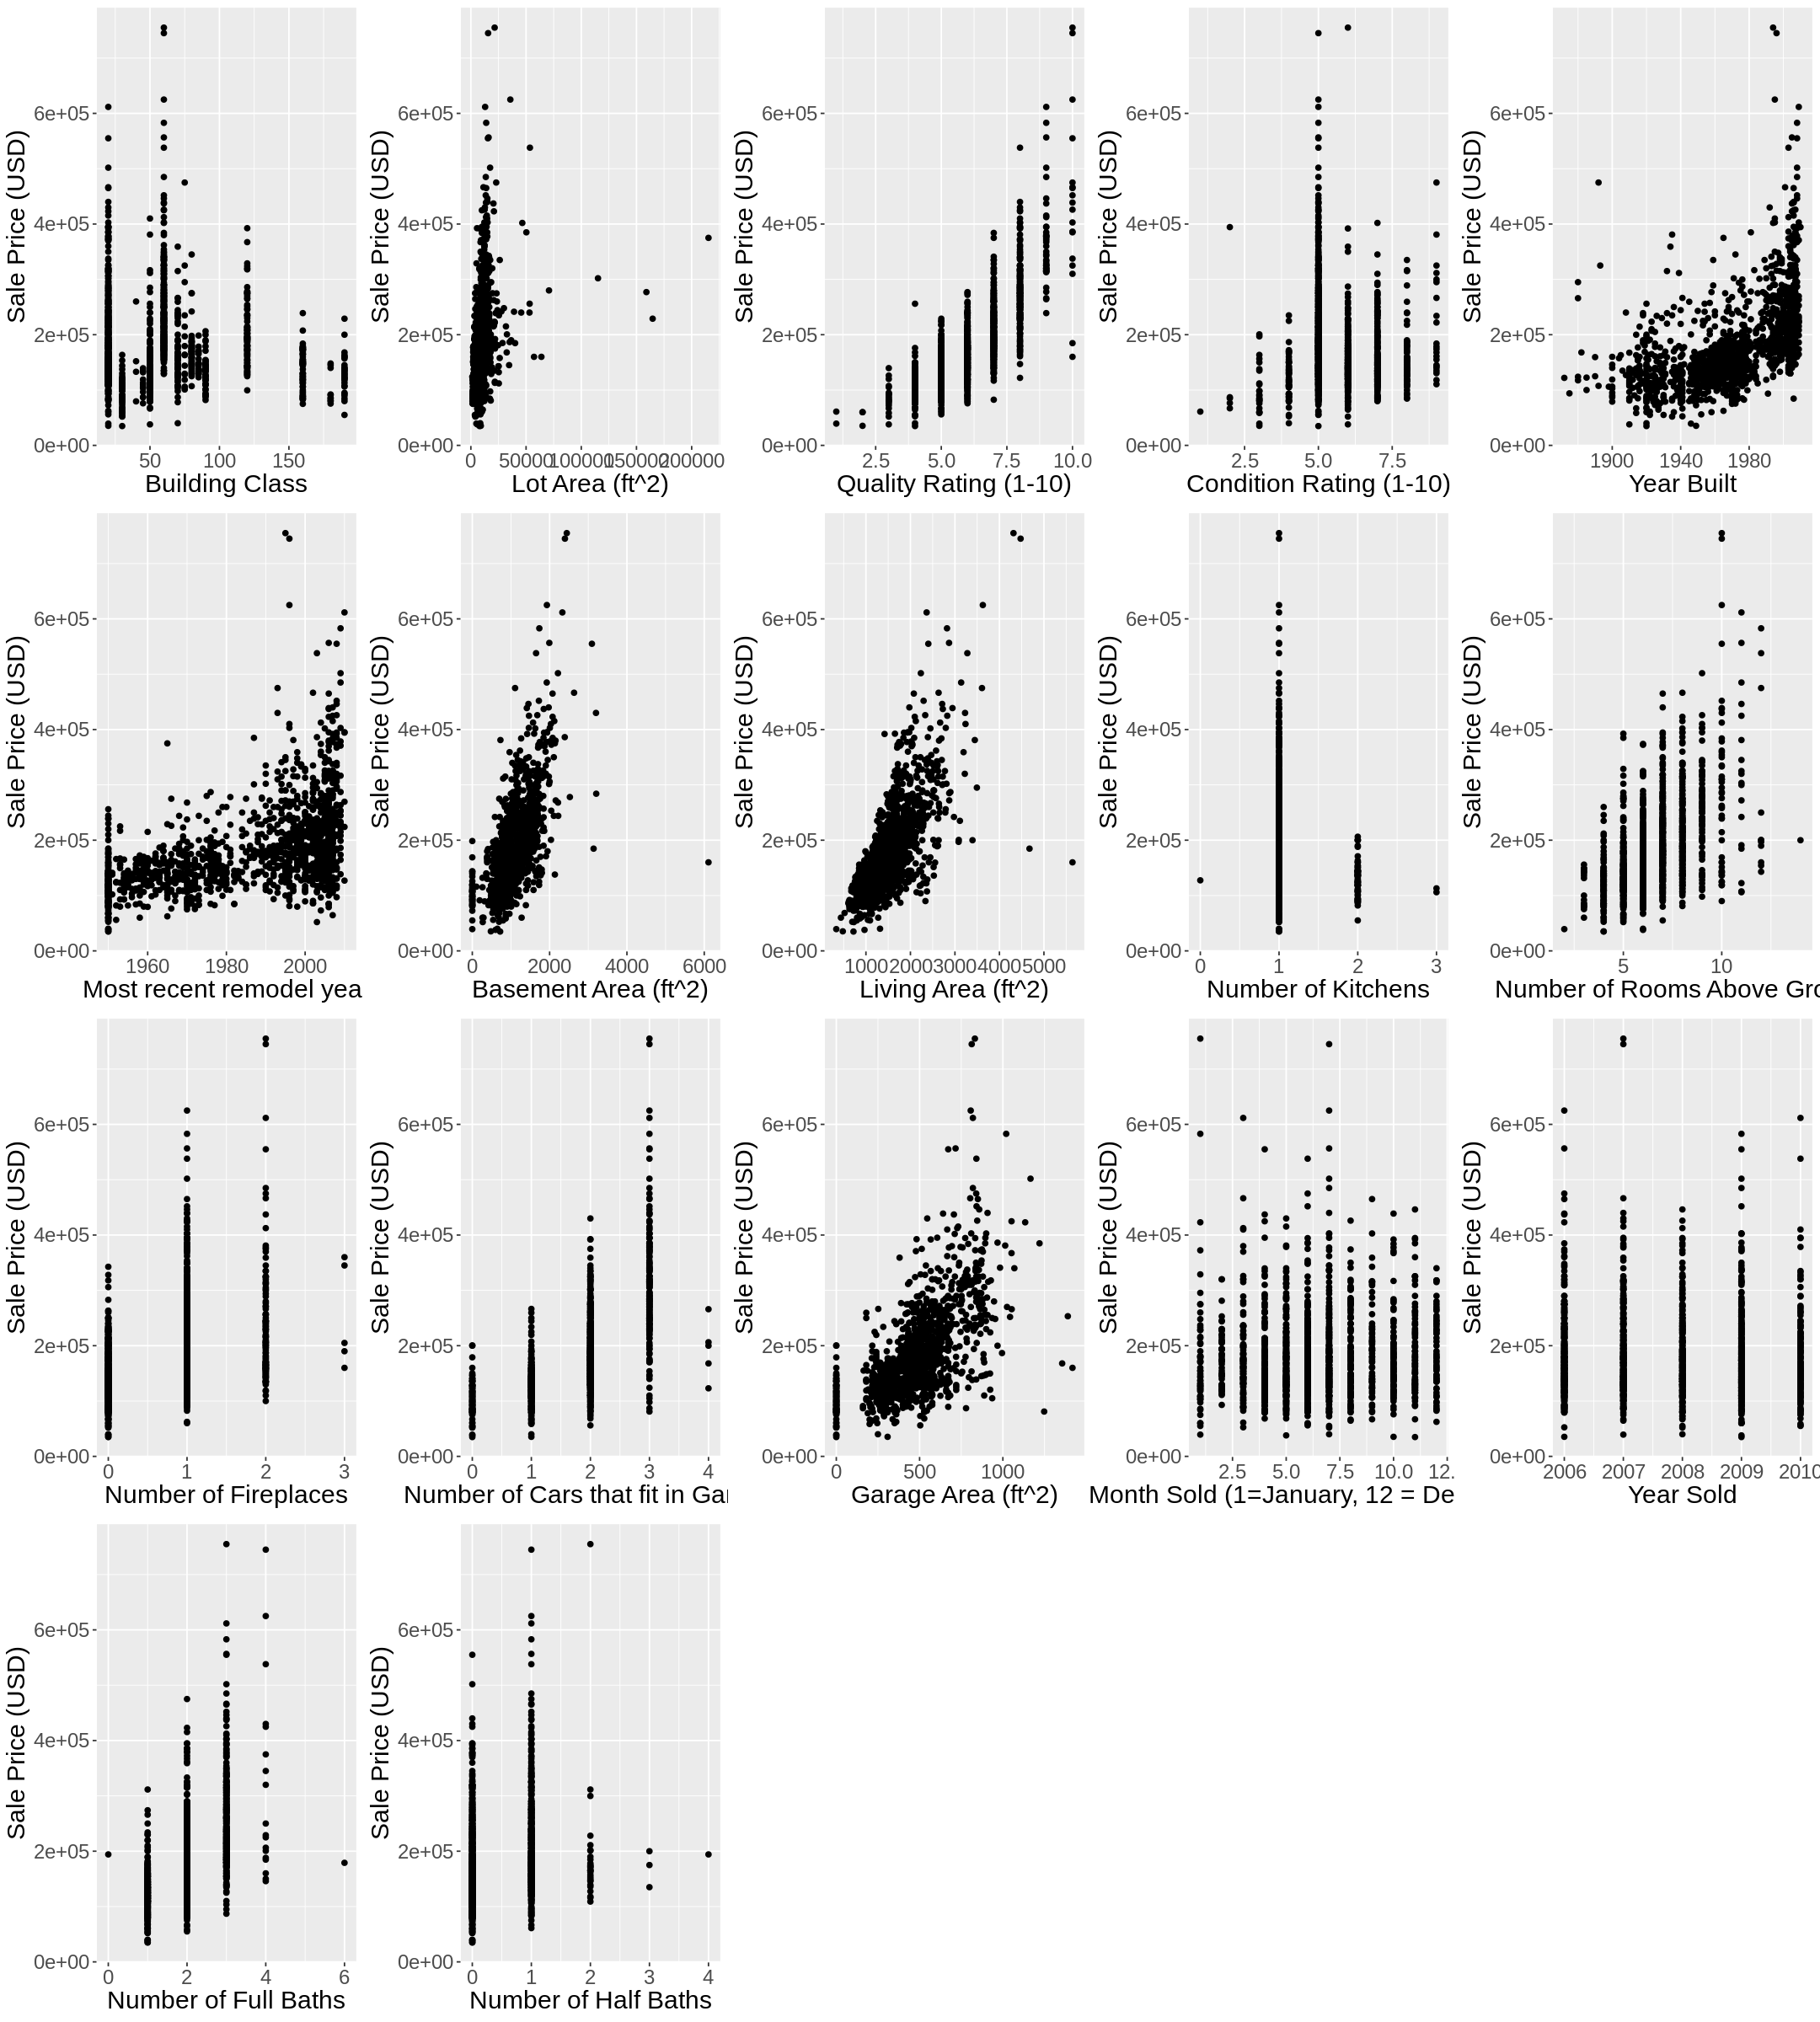

In [8]:
#Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis).
#An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your 
#analysis.

options(repr.plot.width = 18, repr.plot.height = 20)

col_names <- c("Building Class", "Lot Area (ft^2)", "Quality Rating (1-10)", "Condition Rating (1-10)", "Year Built", "Most recent remodel year", "Basement Area (ft^2)", "Living Area (ft^2)","Number of Kitchens","Number of Rooms Above Ground", "Number of Fireplaces", "Number of Cars that fit in Garage", "Garage Area (ft^2)", "Month Sold (1=January, 12 = December)", "Year Sold", "Number of Full Baths", "Number of Half Baths")


data_without_price <- data_selected_numeric %>%
    select(-Id,-SalePrice)

plot_list <- list()

for (i in 1:length(names(data_without_price))){
    new_data <- cbind(x_var = data_without_price[i],y_var = data_selected_numeric$SalePrice)
    new_data <- rename(new_data, x_var = 1)
    plot <- ggplot(new_data, aes(y=y_var, x=x_var)) +
        geom_point() +
        labs(y = "Sale Price (USD)", x = col_names[i]) + theme(text = element_text(size=18))
    plot_list[[i]] <- plot
}

plot_grid(plotlist = plot_list)


## 3. Methods

In order to determine which real estate factors contribute to most accurately predicting the selling price of a home, 
we will construct a multivariate linear regression model. Below is an overview of our proposed data analysis methods:
- Reduce the number of <em>potential</em> explanatory variables from ~80 to ~20 (refer to section 2.2)
- Clean, organize, and summarize the dataset (sections 2.2-2.4)
- Explore and document pairwise relationships using graphical (scatterplot) and statistical (correlation) analysis
- Conduct variable selection analysis to narrow down to a "best subset" of explanatory variables, leveraging the R 'leaps' and 'caret' packages
- Tune model for a final result
- Visualize our results with fitted vs. residual plots

Throughout the process, we will be evaluating not only statistical significance but also interpretability and meaningfulness of our results. Our imperative is to produce a final result that we can explain in plain English.

## 4. Expected outcomes and significance

#### 4.1 Expected findings

We expect to find that size measures (square footage, # of bedrooms, lot size, etc.) of the home will be most positively correlated to selling price. Furthermore, we anticipate that recently renovated homes will exhibit higher predicted values than non-renovated homes. Finally, we expect an element of the unexpected. That is, we hypothesize that we will find factors that will significantly contribute to the selling price of a house for which we were not expecting to drive correlation.

#### 4.2 Potential impact

In our view, there are two notable potential impacts from this work: 
1. Real estate agents and developers could garner a better understanding into the magnitudes of the drivers of home selling prices.
2. We can take key valuation insights with us in our personal life for when we one day purchase homes of our own.

#### 4.3 Potential future questions

Our analysis on factors contributing to the selling price of a home could spark future questions, including:

- How has the weight of each factor that contributes to the selling price changed over time? Is there a pattern to this change?
- Do the factors contributing most to selling prices in Ames, Iowa (our dataset) also hold true for other regions? How would one have to tune the model?